In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from scipy import stats
from collections import namedtuple, Counter

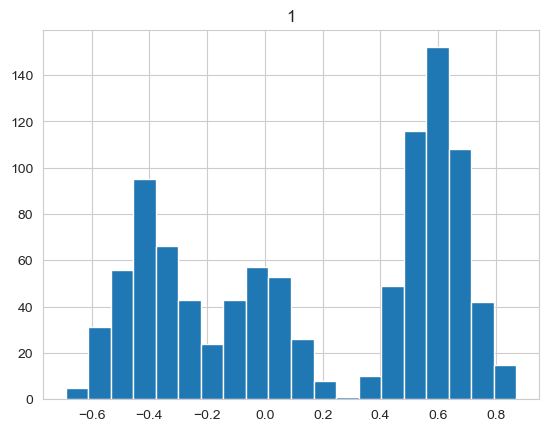

In [2]:
data = pd.read_csv("clusters.csv", header=None)
second_column = data.iloc[:, 1]
data = pd.DataFrame(second_column)
data_array = second_column.values
# data = data.drop('0', axis=1)
_=data.hist(bins=20)

In [3]:
data.size

1000

In [43]:
SuffStat = namedtuple('SuffStat', 'theta N')

def update_suffstats(state):
    for cluster_id, N in Counter(state['assignment']).items():
        points_in_cluster = []
        for x, cid in zip(data_array, state['assignment']):
            if cid == cluster_id:
                points_in_cluster.append(x)
        # points_in_cluster = [x
        #     for x, cid in zip(state['data_'], state['assignment'])
        #     if cid == cluster_id
        # ]
        mean = np.array(points_in_cluster).mean()

        state['suffstats'][cluster_id] = SuffStat(mean, N)

def initial_state():
    num_clusters = 3
    alpha = 1.0
    cluster_ids = range(num_clusters)

    state = {
        'cluster_ids_': cluster_ids,
        'data_': data_array,
        'num_clusters_': num_clusters,
        'cluster_variance_': .01,
        'alpha_': alpha,
        'hyperparameters_': {
            "mean": 0,
            "variance": 1,
        },
        'suffstats': [None, None, None],
        'assignment': [random.choice(cluster_ids) for _ in data.T],
        'pi': [alpha / num_clusters for _ in cluster_ids],
        'cluster_means': [-1, 0, 1]
    }
    update_suffstats(state)
    return state

state = initial_state()

In [44]:
def log_assignment_score(data_id, cluster_id, state):
    """log p(z_i=k \,|\, \cdot)

    We compute these scores in log space for numerical stability.
    """
    x = state['data_'][data_id]
    theta = state['cluster_means'][cluster_id]
    var = state['cluster_variance_']
    log_pi = np.log(state['pi'][cluster_id])
    return log_pi + stats.norm.logpdf(x, theta, var)


def assigment_probs(data_id, state):
    """p(z_i=cid \,|\, \cdot) for cid in cluster_ids
    """
    scores = [log_assignment_score(data_id, cid, state) for cid in state['cluster_ids_']]
    scores = np.exp(np.array(scores))
    if np.all(scores == 0):
        scores = scores + 1
    return scores / scores.sum()


def sample_assignment(data_id, state):
    """Sample cluster assignment for data_id given current state

    cf Step 1 of Algorithm 2.1 in Sudderth 2006
    """
    p = assigment_probs(data_id, state)
    return np.random.choice(state['cluster_ids_'], p=p)


def update_assignment(state):
    """Update cluster assignment for each data point given current state

    cf Step 1 of Algorithm 2.1 in Sudderth 2006
    """
    for data_id, x in enumerate(state['data_']):
        state['assignment'][data_id] = sample_assignment(data_id, state)
    update_suffstats(state)

In [45]:
def sample_cluster_mean(cluster_id, state):
    cluster_var = state['cluster_variance_']
    hp_mean = state['hyperparameters_']['mean']
    hp_var = state['hyperparameters_']['variance']
    ss = state['suffstats'][cluster_id]

    numerator = hp_mean / hp_var + ss.theta * ss.N / cluster_var
    denominator = (1.0 / hp_var + ss.N / cluster_var)
    posterior_mu = numerator / denominator
    posterior_var = 1.0 / denominator

    return stats.norm(posterior_mu, np.sqrt(posterior_var)).rvs()


def update_cluster_means(state):
    state['cluster_means'] = [sample_cluster_mean(cid, state)
                              for cid in state['cluster_ids_']]

In [46]:
def sample_mixture_weights(state):
    """Sample new mixture weights from current state according to
    a Dirichlet distribution

    cf Step 2 of Algorithm 2.1 in Sudderth 2006
    """
    ss = state['suffstats']
    alpha = [ss[cid].N + state['alpha_'] / state['num_clusters_']
             for cid in state['cluster_ids_']]
    return stats.dirichlet(alpha).rvs(size=1).flatten()

def update_mixture_weights(state):
    """Update state with new mixture weights from current state
    sampled according to a Dirichlet distribution

    cf Step 2 of Algorithm 2.1 in Sudderth 2006
    """
    state['pi'] = sample_mixture_weights(state)

In [47]:
def gibbs_step(state):
    update_assignment(state)
    update_mixture_weights(state)
    update_cluster_means(state)

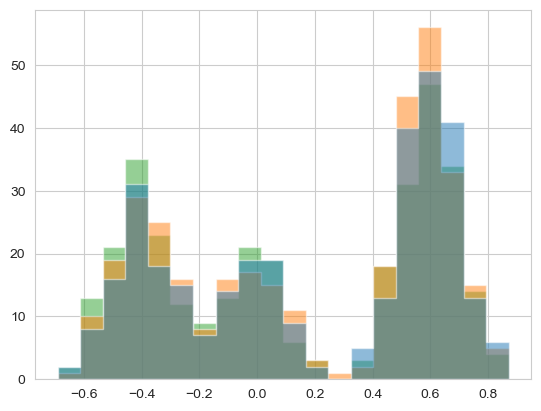

In [48]:
def plot_clusters(state):
    gby = pd.DataFrame({
            'data': state['data_'],
            'assignment': state['assignment']}
        ).groupby(by='assignment')['data']
    hist_data = [gby.get_group(cid).tolist()
                 for cid in gby.groups.keys()]
    plt.hist(hist_data,
             bins=20,
             histtype='stepfilled', alpha=.5 )

plot_clusters(state)

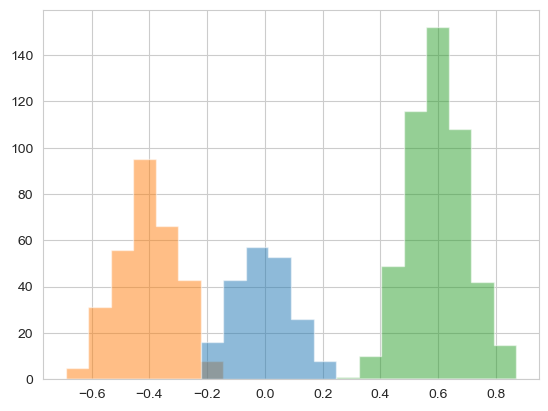

In [49]:
for _ in range(5):
    gibbs_step(state)
plot_clusters(state)

In [51]:
def log_likelihood(state):
    """Data log-likeliehood
    Equation 2.153 in Sudderth
    """
    ll = 0
    for x in state['data_']:
        pi = state['pi']
        mean = state['cluster_means']
        sd = np.sqrt(state['cluster_variance_'])
        ll += np.log(np.dot(pi, stats.norm(mean, sd).pdf(x)))
    return ll

<AxesSubplot: >

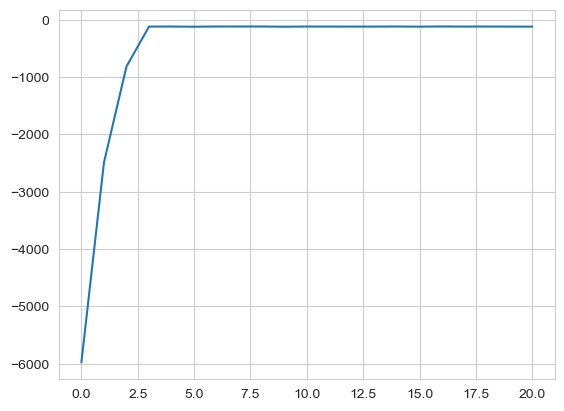

In [54]:
state = initial_state()
ll = [log_likelihood(state)]
for _ in range(20):
    gibbs_step(state)
    ll.append(log_likelihood(state))
pd.Series(ll).plot()

<AxesSubplot: >

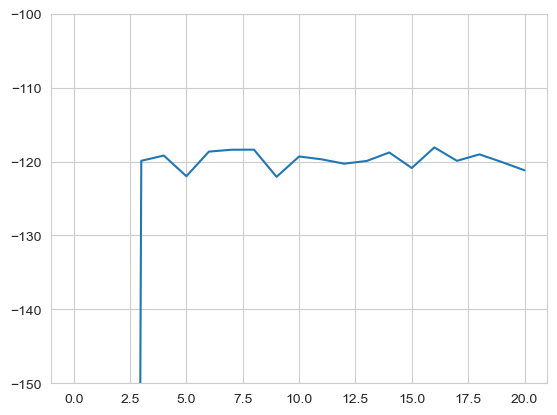

In [56]:
pd.Series(ll).plot(ylim=[-150, -100])